In [3]:
#import primary model choices
import crflux.models as pm
import matplotlib.pyplot as plt
import numpy as np
import os
import MCEq.config as config

#import solver related modules
from MCEq.core import MCEqRun

In [4]:
mceq_run = MCEqRun(
#provide the string of the interaction model
interaction_model='SIBYLL2.3c',
#primary cosmic ray flux model
#support a tuple (primary model class (not instance!), arguments)
primary_model=(pm.HillasGaisser2012, "H3a"),
# Zenith angle in degrees. 0=vertical, 90=horizontal
theta_deg=0.0
)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [9]:
# Bump up the debug level to see what the calculation is doing
config.debug_level = 2

In [10]:
#Define equidistant grid in cos(theta)
angles = np.arccos(np.linspace(1,0,11))*180./np.pi

#Power of energy to scale the flux
mag = 3

#obtain energy grid (nver changes) of the solution for the x-axis of the plots
e_grid = mceq_run.e_grid

p_spectrum_flux = []

#Initialize empty grid
for  pmcount, pmodel in enumerate([(pm.HillasGaisser2012,'H3a'),
                                   (pm.HillasGaisser2012,'H4a'),
                                   (pm.GaisserStanevTilav,'3-gen'),
                                   (pm.GaisserStanevTilav,'4-gen')]):
    
    mceq_run.set_primary_model(*pmodel)
    
    flux = {}
    for frac in ['mu_conv','mu_pr','mu_total',
                 'numu_conv','numu_pr','numu_total',
                 'nue_conv','nue_pr','nue_total','nutau_pr']:
        flux[frac] = np.zeros_like(e_grid)
        

    #Sum fluxes, calculated for different angles
    for theta in angles:
        mceq_run.set_theta_deg(theta)
        mceq_run.solve()
        #_conv means conventional (mostly pions and kaons)
        flux['mu_conv'] += (mceq_run.get_solution('conv_mu+', mag)
                           + mceq_run.get_solution('conv_mu-', mag))

        # _pr means prompt (the mother of the muon had a critical energy
        # higher than a D meson. Includes all charm and direct resonance
        # contribution)
        flux['mu_pr'] += (mceq_run.get_solution('pr_mu+', mag)
                         + mceq_run.get_solution('pr_mu-', mag))

        # total means conventional + prompt
        flux['mu_total'] += (mceq_run.get_solution('total_mu+', mag)
                            + mceq_run.get_solution('total_mu-', mag))

        # same meaning of prefixes for muon neutrinos as for muons
        flux['numu_conv'] += (mceq_run.get_solution('conv_numu', mag)
                             + mceq_run.get_solution('conv_antinumu', mag))
        flux['numu_pr'] += (mceq_run.get_solution('pr_numu', mag)
                           + mceq_run.get_solution('pr_antinumu', mag))

        flux['numu_total'] += (mceq_run.get_solution('total_numu', mag)
                              + mceq_run.get_solution('total_antinumu', mag))

        # same meaning of prefixes for electron neutrinos as for muons
        flux['nue_conv'] += (mceq_run.get_solution('conv_nue', mag)
                            + mceq_run.get_solution('conv_antinue', mag))

        flux['nue_pr'] += (mceq_run.get_solution('pr_nue', mag)
                          + mceq_run.get_solution('pr_antinue', mag))

        flux['nue_total'] += (mceq_run.get_solution('total_nue', mag)
                             + mceq_run.get_solution('total_antinue', mag))


        # since there are no conventional tau neutrinos, prompt=total
        flux['nutau_pr'] += (mceq_run.get_solution('total_nutau', mag)
                            + mceq_run.get_solution('total_antinutau', mag))

    #average the results
    for frac in ['mu_conv','mu_pr','mu_total',
                 'numu_conv','numu_pr','numu_total',
                 'nue_conv','nue_pr','nue_total','nutau_pr']:
        flux[frac] = flux[frac]/float(len(angles))
        
    p_spectrum_flux.append((flux,mceq_run.pmodel.sname,mceq_run.pmodel.name)) 

MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_theta_deg(): Zenith angle   0.00
MCEqRun::solve(): Launching euler solver
MCEqRun::_calculate_integration_path(): X_surface = 1033.81g/cm2
MCEqRun::solve(): for 594 integration steps.
solv_numpy(): Performance:   4.94ms/iteration
MCEqRun::solve(): time elapsed during integration:  2.93sec
MCEqRun::set_theta_deg(): Zenith angle  25.84
MCEqRun::solve(): Launching euler solver
MCEqRun::_calculate_integration_path(): X_surface = 1148.37g/cm2
MCEqRun::solve(): for 658 integration steps.
solv_numpy(): Performance:   4.95ms/iteration
MCEqRun::solve(): time elapsed during integration:  3.26sec
MCEqRun::set_theta_deg(): Zenith angle  36.87
MCEqRun::solve(): Launching euler solver
MCEqRun::_calculate_integration_path(): X_surface = 1291.43g/cm2
MCEqRun::solve(): for 737 integration steps.
solv_numpy(): Performance:   4.94ms/iteration
MCEqRun::solve(): time elapsed during integration:  3.64sec
MCEqRun::set_theta_deg(): Zenith angle 

In [7]:
#get path of the home directory + Desktop
desktop = os.path.join(os.path.expanduser("~"),'Desktop')

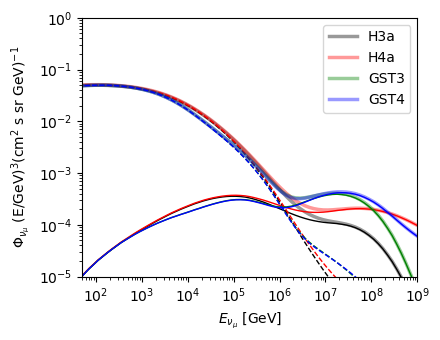

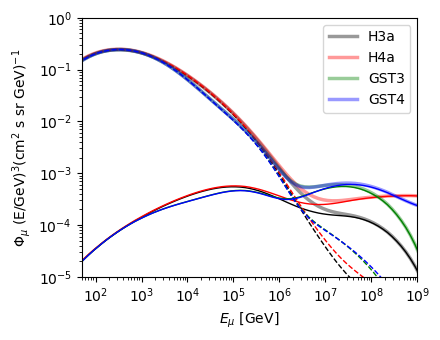

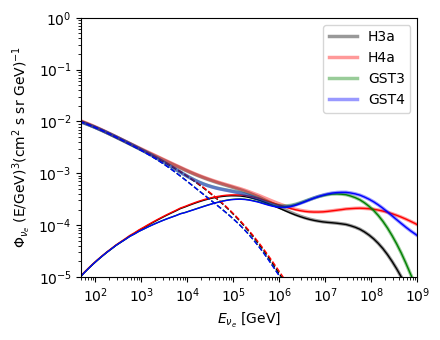

In [8]:
for pref, lab in [('numu_',r'\nu_\mu'), 
                  ('mu_',r'\mu'), 
                  ('nue_',r'\nu_e')
                 ]:
    plt.figure(figsize=(4.5, 3.5))
    for (flux, p_sname, p_name), col in zip(p_spectrum_flux,['k','r','g','b','c']):
        
        plt.loglog(e_grid, flux[pref + 'total'], color=col, ls='-', lw=2.5,
                  label=p_sname, alpha=0.4)
        plt.loglog(e_grid, flux[pref + 'conv'], color=col, ls='--', lw=1,
                   label='_nolabel_')
        plt.loglog(e_grid, flux[pref + 'pr'], color=col,ls='-', lw=1, 
                   label='_nolabel_')
    plt.xlim(50,1e9)
    plt.ylim(1e-5,1)
    plt.xlabel(rf"$E_{{{lab}}}$ [GeV]")
    plt.ylabel(r"$\Phi_{" + lab + "}$ (E/GeV)$^{" + str(mag) +" }$" + 
               "(cm$^{2}$ s sr GeV)$^{-1}$")
    plt.legend(loc='upper right')
    plt.tight_layout()

    # Uncoment if you want to save the plot
    plt.savefig(os.path.join(desktop,pref + 'flux.pdf'))

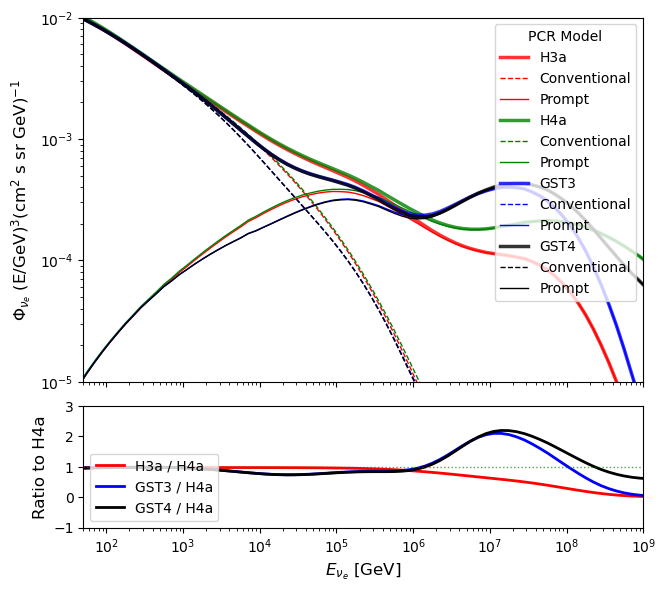

In [31]:
# 1. Isolate the electron neutrino data and H3a reference
nue_data = []
h4a_flux_nue = None
h4a_sname = 'H4a'
nue_pref = 'nue_'
nue_lab = r'\nu_e'

# Define your custom color scheme - GST3 set to blue
custom_model_colors = {'H3a': 'r', 'H4a': 'g', 'GST3': 'b', 'GST4': 'k'}

for flux_data, p_sname, p_name in p_spectrum_flux:
    nue_data.append((flux_data, p_sname, p_name))
   
    if p_sname == h4a_sname:
        h4a_flux_nue = flux_data[nue_pref + 'total']

if h3a_flux_nue is None:
    print(f"Error: Total electron neutrino flux for {h4a_sname} not found.")
    print("Available models:", [p_sname for _, p_sname, _ in p_spectrum_flux])
else:
    # 2. Setup the Combined Figure
    figsize = (7, 6)
    fig = plt.figure(figsize=figsize)
    
    # Create a gridspec with adjusted parameters
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.1,
                         left=0.15, right=0.95, bottom=0.1, top=0.95)
    
    # Upper plot for the Spectrum (ax1)
    ax1 = fig.add_subplot(gs[0])
    # Lower plot for the Ratio (ax2), sharing the x-axis
    ax2 = fig.add_subplot(gs[1], sharex=ax1) 
    
    # 3. Plot the Spectrum (ax1) - REMOVED THE SKIPPING
    for flux_data, p_sname, p_name in nue_data:
        
        col = custom_model_colors.get(p_sname, 'k')
        
        # Total Flux (Thick Solid) - Labeled
        ax1.loglog(e_grid, flux_data[nue_pref + 'total'], color=col, ls='-', lw=2.5,
                  label=p_sname, alpha=0.8)
        # Conventional Flux (Thin Dashed) - Unlabeled
        ax1.loglog(e_grid, flux_data[nue_pref + 'conv'], color=col, ls='--', lw=1,
                   label='Conventional')
        # Prompt Flux (Thin Solid) - Unlabeled
        ax1.loglog(e_grid, flux_data[nue_pref + 'pr'], color=col,ls='-', lw=1, 
                   label='Prompt')
        
    # Aesthetics for ax1
    ax1.set_xlim(50,1e9)
    ax1.set_ylim(1e-5,1e-2)
    ax1.set_ylabel(r"$\Phi_{" + nue_lab + "}$ (E/GeV)$^{" + str(mag) +" }$" + 
                   "(cm$^{2}$ s sr GeV)$^{-1}$", fontsize=12)
    ax1.legend(loc='upper right', title="PCR Model")
    
    # Hide x-labels from the upper plot
    plt.setp(ax1.get_xticklabels(), visible=False) 
    
    # 4. Plot the Ratio (ax2) - REMOVED THE SKIPPING
    ratio_model_ls = {'H3a': '-', 'H4a': '-', '3-gen': '--', '4-gen': ':'}
    
    for flux_data, p_sname, p_name in nue_data:
            
        if p_sname != h4a_sname:
            ratio = flux_data[nue_pref + 'total'] / h4a_flux_nue
            ls = ratio_model_ls.get(p_sname, '-') 
            color = custom_model_colors.get(p_sname, 'k')
            label = f'{p_sname} / {h4a_sname}'
            
            ax2.semilogx(e_grid, ratio, color=color, ls=ls, lw=2, label=label)

    # Add a horizontal line at y=1.0 for the H3a reference
    ax2.axhline(1.0, color=custom_model_colors[h4a_sname], linestyle=':', alpha=0.7, lw=1)
    
    # Aesthetics for ax2
    ax2.set_xlim(50,1e9)
    ax2.set_ylim(-1, 3)
    ax2.set_xlabel(rf"$E_{{{nue_lab}}}$ [GeV]", fontsize=12)
    ax2.set_ylabel(r"Ratio to H4a", fontsize=12)
    ax2.legend(loc='lower left')
    
    plt.savefig(os.path.join(desktop, 'nue_combined_plot.pdf'), 
                bbox_inches='tight', dpi=300)
    
    plt.show()